# Формирование модели монетизации в мобильной игре «Космические братья»

#  Материалы:

[Презентация](#one) (https://disk.yandex.ru/i/SIgwRbM3OvXpMA)

[Дашборд](#one_one) (https://public.tableau.com/app/profile/tatiana7816/viz/__new/Dashboard1?publish=yes)

Планируется монетизация мобильной игры. Предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Для анализа представлены данные по игре пользователей на первом уровне.
Завершение первого уровня требует от игрока выполнения одного из двух условий:

Победа над первым врагом

Реализация проекта - разработка орбитальной сборки спутников


# Задача проекта

Рекомендации по формированию наиболее оптимальной модели монетизации мобильной игры  на основании предоставленных данных.
По условиям стоимость одного клика показа рекламы пользователю составляет - **0.07 у.е.** и увеличивать данную стоимость **не можем**  **категорически.**

**ОПИСАНИЕ ДАННЫХ**

**Датасет game_actions.csv:**

event_datetime — время события;

event — одно из трёх событий:

1. building — объект построен

2. finished_stage_1 — первый уровень завершён

3. project — проект завершён;


building_type — один из трёх типов здания:

1. assembly_shop — сборочный цех

2. spaceport — космопорт

3. research_center — исследовательский центр;


user_id — идентификатор пользователя;
project_type — тип реализованного проекта;



**Датасет ad_cost.csv:**


day - день, в который был совершен клик по объявлению


source - источник трафика


cost - стоимость кликов




**Датасет user_source.csv:**


user_id - идентификатор пользователя

source - источников, с которого пришёл пользователь, установивший приложение

Для проведения анализа в датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

# План работы:

[1. Изученние данных](#share)

[2. Предобработка данных](#two)

[3. Исследовательский анализ данных (EDA)](#three)

[3.1 Расчет количества пользователей и событий по периоду.](#three_1)

[3.2 Расчет количества пользователей и событий в зависимости от источника перехода пользователя в игру (трафика).](#three_2)

[3.3 Исследование количества пользователей и событий в зависимости от выбранной пользователем стратегии.](#three_3)

[3.4 Расчет расходов на рекламу в зависимости от источника, продуктовые метрики .](#three_4)

[4. Проверка гипотез](#four)

[4.1 Время прохождения уровня игры различается между пользователями в зависимости способа завершения уровня: через реализацию проекта либо через победу над другим игроком ](#four_1)

[4.2 Время прохождения уровня игры различается в зависимости от источника перехода пользователя в игровое приложение](#four_2)

[5.Оценка предполагаемой (разработанной до проведения анализа) модели монетизации](#five)


[6. Общие выводы и рекомендации по формированию модели монетизации игрового приложения](#six)

<a id="share"></a> 
## Изучение данных

In [1]:
# загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats as st
from IPython.display import display
from datetime import datetime, timedelta
pd.set_option('display.float_format', '{:,.2f}'.format)
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [2]:
# прочитаем датасеты
df_game_actions = pd.read_csv('.......csv')
df_costs = pd.read_csv('.......csv')
df_user_source = pd.read_csv('.......csv')

In [3]:
def df_information(df):
    """
    функция показывает информацию по датасету (sample(), info(), describe(), пропуски, дубликаты
    параметры функции:
        `df` - датасет
    """    
    display(df.sample(n=10, random_state=123))
    print('*'*50)
    print(df.info())
    print('*'*50)
    display(df.describe())
    print('*'*50)
    print('Пропуски:')
    print(df.isna().sum())
    print('*'*50)
    print('Дубликаты:', df.duplicated().sum()) 


In [4]:
df_information(df_game_actions)

,event_datetime,event,building_type,user_id,project_type
69952,2020-05-10 11:03:55,building,assembly_shop,ffa97b04-7e37-4ac3-9ec3-34f31437186a,NaN
43597,2020-05-08 11:14:45,building,assembly_shop,7b96354b-1646-4ea5-93b7-bbd431e08f85,NaN
72201,2020-05-10 14:39:13,building,spaceport,efc9b880-f4c8-4077-a568-161fd917b84d,NaN
34287,2020-05-07 15:52:34,building,spaceport,48ae70bf-3856-4e16-ba69-db35053e490a,NaN
16604,2020-05-05 22:15:14,building,assembly_shop,03184236-af55-48fe-b67e-c2bcd8290332,NaN
18559,2020-05-06 03:16:44,building,assembly_shop,96840a10-df2b-477c-837a-31604e4390c4,NaN
77679,2020-05-10 22:56:57,finished_stage_1,NaN,9f7a3aed-87f1-4c66-a406-31124f402bae,NaN
112458,2020-05-15 13:40:09,building,spaceport,93af2dd5-c57b-4582-96db-7a05ed6692d5,NaN
57103,2020-05-09 13:14:25,building,assembly_shop,54e57b48-4907-4edb-9c8e-ede623b39803,NaN
87698,2020-05-12 03:17:40,building,spaceport,28d15f34-d1f2-4d25-b632-f74f6e7e917d,NaN


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
None
**************************************************


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


**************************************************
Пропуски:
event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64
**************************************************
Дубликаты: 1


**Вывод:** 

- В датасете 135640 событий, совершенных  уникальными пользователями в количестве - 13576 чел.
- Один дубликат, в дальнейшем удалим
- Следует заменить тип данных столбца "event_datetime" на datetime
- В столбце "building_type"  7683 пропусков - в соответствии с условиями задания и описанием данных данный столбец отображает тип объекта строительства, поэтому пропуски в данном столбце допустимы, так как игрок может находиться только на стадии строительства здания, либо не строить объект, а путем победы над врагом перейти на следующий уровень игры.
- В столбце "project_type" (тип реализованного проекта) - 133774 пропуска. Это достаточно большое количество пропущенных значений, в связи с чем мы обратились в технический отдел за разъяснениями. Получена уточняющая информация по данному полю данных, а именно: в данном столбце содержится информация только если событие было типом проекта. Так как мы изучаем данные только для игроков, которые прошли первый уровень игры, тип проекта будет для всех игроков одинаков и пропуски при заполнении данного поля обусловлены механикой сбора данных, что является в данном случае нормой. Пропуски в данном столбце заменим на "none", для удобства использования этих данных при дальнейшей работе над проектом.



In [5]:
df_information(df_costs)

,source,day,cost
24,youtube_channel_reklama,2020-05-06,88.51
5,facebook_ads,2020-05-08,68.01
7,instagram_new_adverts,2020-05-03,943.20
8,instagram_new_adverts,2020-05-04,502.93
25,youtube_channel_reklama,2020-05-07,55.74
11,instagram_new_adverts,2020-05-07,109.92
20,yandex_direct,2020-05-09,42.78
21,youtube_channel_reklama,2020-05-03,454.22
12,instagram_new_adverts,2020-05-08,71.58
27,youtube_channel_reklama,2020-05-09,23.31


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None
**************************************************


,cost
count,28.00
mean,271.56
std,286.87
min,23.31
25%,66.75
50%,160.06
75%,349.03
max,969.14


**************************************************
Пропуски:
source    0
day       0
cost      0
dtype: int64
**************************************************
Дубликаты: 0


In [6]:
# посмотрим на уникальные значения источников трафика, так как пока не понятно сколько их и какие
print('Источники:', df_costs['source'].unique())

Источники: ['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']


**Вывод:**

- В датасете 28 записей
- Датасет содержит данные по 4-м уникальным источникам трафика, а именно: 'facebook_ads', 'instagram_new_adverts','yandex_direct', 'youtube_channel_reklama'
- Пропусков и дубликатов нет
- Тип данных в столбце 'day' заменим на тип datetime



In [7]:
df_information(df_user_source)

,user_id,source
8069,97ff1d22-4212-4c0f-ac8b-6186fed25ef3,facebook_ads
10833,cca6e739-765f-46bb-9a83-73f87c2a1935,instagram_new_adverts
4797,58f27280-6f93-4030-ae90-7270c707060a,facebook_ads
5526,66d1d3b7-3850-4256-9487-d056c6f731a3,facebook_ads
4395,511c3e12-1aed-42c5-9c6b-dfa5eff40d8a,yandex_direct
3597,427bec51-94ed-4fdb-80db-46076e31d7c0,yandex_direct
2615,2f9dfcb2-21bf-4aab-8a66-e7dca69956a5,yandex_direct
3155,39ac549c-c649-4119-a761-e1a7a8ad37f1,facebook_ads
11390,d7aeeb77-4133-40dc-91b5-4cfbee8ab54c,yandex_direct
6984,822041d8-ee68-44a1-8cd1-7c5e979ab8a7,instagram_new_adverts


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
None
**************************************************


,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


**************************************************
Пропуски:
user_id    0
source     0
dtype: int64
**************************************************
Дубликаты: 0


In [8]:
# посмотрим на уникальные значения по источникам в данном датасете
print(df_user_source['source'].unique())

['facebook_ads' 'yandex_direct' 'youtube_channel_reklama'
 'instagram_new_adverts']


**Вывод:**

- Пропусков и дубликатов нет
- Количество и наименования источников совпадают с датасетом df_costs

<a id="two"></a> 
## Предобработка данных

In [9]:
# Изменим тип данных
df_game_actions['event_datetime'] = pd.to_datetime(df_game_actions['event_datetime'], format='%Y-%m-%d %H:%M:%S')
df_costs['day'] = pd.to_datetime(df_costs['day'], format='%Y-%m-%d')

In [10]:
# проверим результат
df_game_actions.info()
print('*'*50)
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


In [11]:
# Добавим в датасет "df_game_actions" столбец "date" ,
# в котором оставим только дату без указания времени для удобства дальнейшей работы с данными
# проверим результат

df_game_actions['date'] = df_game_actions['event_datetime'].dt.date.astype('datetime64')
display(df_game_actions.head())

,event_datetime,event,building_type,user_id,project_type,date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04


In [12]:
# заменим пропуски в столбце "project_type" и проверим результат

df_game_actions['project_type'] = df_game_actions['project_type'].fillna('none')
display(df_game_actions.head())

,event_datetime,event,building_type,user_id,project_type,date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,none,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,none,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,none,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,none,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,none,2020-05-04


In [13]:
# удалим дубликат и проверим результат
df_game_actions = df_game_actions.drop_duplicates()
df_game_actions.duplicated().sum()

0

**Вывод:**

Данные датасетов обработаны корректно и готовы для дальнейшего проведения анализа.

<a id="three"></a> 
## Исследовательский анализ данных

<a id="three_1"></a> 
### Расчет количества пользователей и событий за изучаемый  период

In [14]:
# создадим функцию для расчета уникальных пользователей и количества событий с построением графиков распределения
# также выводит describe сгрупированных данных

def calculation(df, gr_interval, name_interval):  
    """
   Параметры функции:
        `df` - датафрейм с информацией о событиях в игре
        `gr_interval` - список столбцов для группировки по периоду
        `name_interval` - название периода 
    """
    nums = (df.groupby(gr_interval)
                  .agg(
                      user_count = ('user_id','nunique'),
                      event_count = ('user_id','count'))
             )
    nums['events_per_user'] = nums['event_count'] /  nums['user_count']
    nums = nums.sort_values(by=gr_interval)
    nums[['user_count', 'event_count']].plot(figsize=(15,5), kind='bar', grid=True,
                                               title='количество пользователей/событий в '+ name_interval, colormap='winter')
    plt.xlabel('')
    plt.ylabel('количество пользователей/событий')
    plt.legend(['пользователи','события'])
    plt.show()

    plt.figure(figsize=(12,7))
    sns.distplot(nums['user_count'], bins=12, label='пользователи', color='blue')
    sns.distplot(nums['event_count'], bins=12, label='события', color='green')
    plt.title('распределение количества пользователей/событий в ' + name_interval)
    plt.xlabel('распределение')
    plt.ylabel('плотность')
    plt.legend()
    plt.show() 
    
    display(nums.describe())

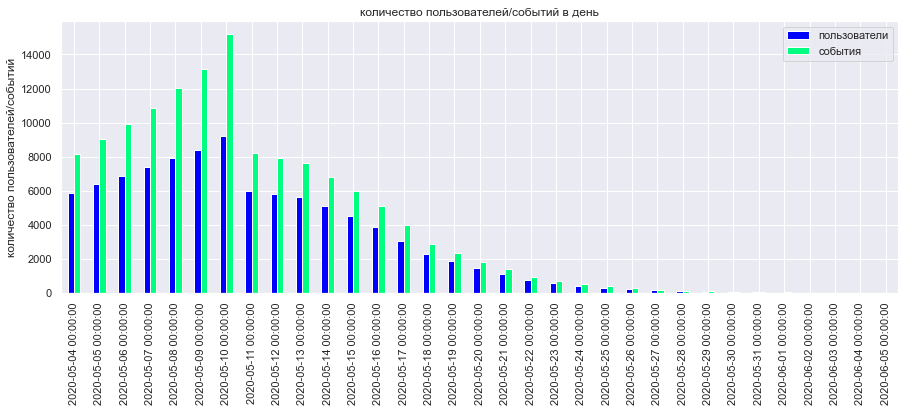

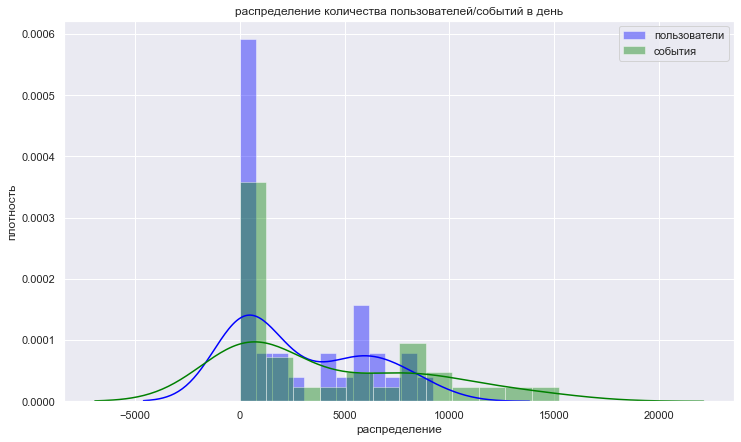

,user_count,event_count,events_per_user
count,33.00,33.00,33.00
mean,"2,884.88","4,110.27",1.33
std,"3,083.78","4,639.71",0.11
min,4.00,5.00,1.22
25%,91.00,118.00,1.25
50%,"1,480.00","1,837.00",1.30
75%,"5,776.00","7,918.00",1.37
max,"9,219.00","15,207.00",1.65


In [15]:
calculation(df_game_actions, ['date'], 'день')

In [16]:

print('Всего количество уникальных пользователей:', df_game_actions['user_id'].nunique())

Всего количество уникальных пользователей: 13576


#### Вывод

Всего колечество уникальных пользователей - **13576** чел.
Видим, что среднее количество пользователей в день - 2884. Минимальное количество пользователей в день снижается до 4-х, максимально до  9219.  Для проведения анализа предоставлены данные о пользователях, которые начали игру с 4 по 10 мая, из графика видим, что период игры этих пользователей с 04.05.20 по 05.06.20.  Распределение смещено вправо.

Среднее количество событий за период предоставленный период - 4111 в день, из которых минимум 5 событий и максимум - 15207. Распределение также смещено вправо. 

Также наблюдаем ежедневное нарастание количества пользователей и событий, но уже с 10.05.20 происходит резкое снижение этих показателей, что может быть обусловлено: либо окончанием периода выходных и праздничных дней, либо тем, что пользователи перешли на следующий уровень, так как было достаточно этого времени игры (их активность в показателях после 10 мая не видна).  

Среднее количество событий на одного пользователя в день - 1.33. 



In [17]:
# Добавим в датасет `df_game_actions` информацию об источнике
df_game_actions = df_game_actions.merge(df_user_source, how='left', on='user_id')

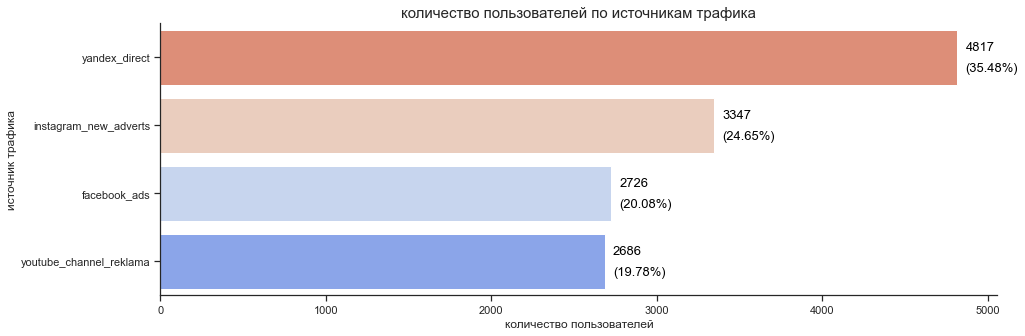

,user_count,event_count,events_per_user
source,,,
yandex_direct,4817,47694,9.90
instagram_new_adverts,3347,33757,10.09
facebook_ads,2726,27672,10.15
youtube_channel_reklama,2686,26516,9.87


In [18]:
# сгруппируем данные по пользователям и событиям в зависимости от источника трафика
amount = df_game_actions.groupby('source').agg(user_count = ('user_id', 'nunique'), event_count = ('user_id', 'count'))

# расчитаем количество событий на одного пользователя в зависимости от источника трафика

amount['events_per_user'] = amount['event_count'] / amount['user_count']
amount = amount.sort_values('user_count', ascending=False)

# построим график
sns.set_style("ticks")
plt.figure(figsize=(15, 5))
plt.title('количество пользователей по источникам трафика', fontsize = 15)
sns.barplot(y=amount.index, x=amount['user_count'], palette='coolwarm_r', orient='h')

for i, g in enumerate(amount['user_count'].values):
    plt.text(g + 50, i - 0.1, str(g), fontsize = 13, color='black' )
    plt.text(g + 50, i + 0.2, '({:.2%})'.format(g / amount['user_count'].sum()), fontsize = 13, color='black')

plt.xlabel('количество пользователей')
plt.ylabel('источник трафика')
sns.despine()
plt.show()

display(amount)

,index,event_count,%_of_total
0,building,127956,94.34
1,finished_stage_1,5817,4.29
2,project,1866,1.38


Общее количество совершенных событий: 135639


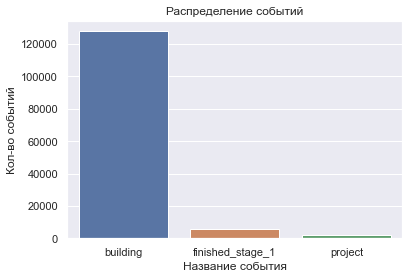

In [19]:
# расчитаем  количество событий в процентном отношении за весь период

count_events = df_game_actions['event'].value_counts().reset_index().rename({'event':'event_count'}, axis=1)
count_events['%_of_total'] = ((count_events['event_count'] / count_events['event_count'].sum())*100).round(2)
display(count_events)
print('Общее количество совершенных событий:', count_events['event_count'].sum())

sns.set_style("darkgrid")
sns.countplot(df_game_actions['event'])
plt.title('Распределение событий')
plt.ylabel('Кол-во событий')
plt.xlabel('Название события');





#### Вывод

Общее количество совершенных событий пользователями составляет- 135 639. Из них 94 % приходится на события строительства (всего построено **127 956** объектов), 4,29 % - на завершение уровня путем победы над врагом и 1,38 % - на завершение уровня стратегией строительства.
Из произведенных расчетов и визуализации видим следующее:  самое высокое количество пользователей переходят из источника Яндекс Директ - 4817 (35,48 %)  чел., на втором месте по численности пользователи трафика Инстаграмм - 3347 (24,65 %) чел., Ютюб и Фейсбук привлекают практически одинаковое количество пользователей : 2686 (20,08 %) и 2726 (19,78 %) соответственно.

Относительно совершенных событий: пользователи трафика Яндекс Директ совершают самое большое количество событий - 47694, что логично, так как и пользователей переходит из этого источника больше. На втором месте по совершению событий пользователи трафика Инстаграмм - 33 757, и далее по убыванию Фейсбук - 27 672 события и Ютуб - 26 516 событий.



<a id="three_3"></a> 
### Исследование количества пользователей и событий в зависимости от выбранной пользователем стратегии

Условия мобильной игры таковы, что игроки переходят на следующий уровень при выполнении следующих условий:

- победа над первым врагом 
- реализация проекта - разработка орбитальной сборки спутников


Каждый завершивший уровень игрок проходит в событие 'finished_stage_1'. Игроки, которые прошли уровень путём реализации проекта, проходят еще событие - 'project'. Игроки, которые  имеют событие finished_stage_1, но не прошли событие 'project', закончили первый уровень победой над врагом.

Количество игроков, прошедших первый уровень путём стратегии строительства: 1866
Количество игроков, прошедших первый уровень путём победы над первым врагом: 3951
Всего игроков, прошедших первый уровень: 5817 


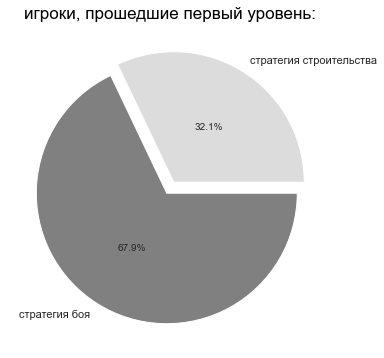

In [20]:
# расчитаем количество игроков, которые прошли первый уровень в зависимости от стратегии

amount_finish = df_game_actions[df_game_actions['event'] == 'finished_stage_1']['user_id'].count()

# игроки, которые прошли уровень посредством строительства
bild_finish = df_game_actions[df_game_actions['event'] == 'project']['user_id'].count() 

# игроки, которые прошли уровень посредством победы
victory_finish = amount_finish - bild_finish

print('Количество игроков, прошедших первый уровень путём стратегии строительства:', bild_finish)
print('Количество игроков, прошедших первый уровень путём победы над первым врагом:', victory_finish)
print('Всего игроков, прошедших первый уровень:\033[94m', amount_finish, '\033[0m')

pie_part = pd.Series([bild_finish, victory_finish], index=['стратегия строительства','стратегия боя'])

pie, ax = plt.subplots(figsize=[10,6])
colors = ( "gainsboro", "gray") 
labels = pie_part.keys()
plt.pie(x=pie_part, autopct="%.1f%%", explode=[0.05]*2, labels=labels, colors=colors, pctdistance=0.5)
plt.title("игроки, прошедшие первый уровень:", fontsize=17,color='black');

plt.show()

Создаем объединенную таблицу для удобства дальнейшего исследования и добавим в нее столбцы с прогрессом прохождения игры в зависимости от стратегии, временем прохождения уровня, максимальную и минимальную дату нахождения пользователя в игре.

In [21]:
# Справочник со списком уникальных событий по каждому пользователю:
ev_per_user = df_game_actions.groupby('user_id')['event'].unique()

In [22]:
# Создаем функцию, которая определяет стратегию игрока и его статус относительно окончания уровня игры

def level(row):
    if row['event'] == 'project': # первый уровень завершён строительством
        return 'builder'
    if row['event'] == "finished_stage_1": # первый уровень завершён 
        if 'project' in ev_per_user[row['user_id']]: # и разработана орбитальная сборка спутников
            return 'builder'
        else:                                           
            return 'winner_battle'                    # первый уровень завершен победой над врагом 
    else:
        return 'not_finish_level'                     # в процессе прохождения уровня

In [23]:
df_game_actions['status_strategy'] = df_game_actions.apply(lambda x: level(x), axis=1)
display(df_game_actions.head())

,event_datetime,event,building_type,user_id,project_type,date,source,status_strategy
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,none,2020-05-04,youtube_channel_reklama,not_finish_level
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,none,2020-05-04,facebook_ads,not_finish_level
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,none,2020-05-04,instagram_new_adverts,not_finish_level
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,none,2020-05-04,facebook_ads,not_finish_level
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,none,2020-05-04,yandex_direct,not_finish_level


In [24]:
df_good = df_game_actions.groupby(['user_id', 'event'])['user_id'].count().unstack(level=1).reset_index()

# удалим лишнее
df_good = df_good.drop(columns = ['finished_stage_1', 'project'])


# добавим информацию о количестве построенных объектов каждого типа

build_amount = df_game_actions.groupby(['user_id', 'building_type'])['user_id'].count().unstack(level=1).reset_index()
df_good = df_good.merge(build_amount, how='left', on='user_id')

# присоединим информацию об источнике перехода пользователя
df_good = df_good.merge(df_user_source, how='left', on='user_id')

# присоединим информацию о первом действии пользователя в игре
first_datetime = df_game_actions.groupby(['user_id']).agg(first_event_datetime = ('event_datetime', 'min')).reset_index()
df_good = df_good.merge(first_datetime, how='left', on='user_id')

# присоединим информацию о последнем статусе игрока
last_status = df_game_actions.groupby(['user_id'])['event_datetime'].max().reset_index()
last_status = last_status.merge(df_game_actions, how='left', left_on=['user_id', 'event_datetime'], right_on=['user_id', 'event_datetime'])

# Удалим лишние поля:
last_status = last_status.drop(columns = ['event', 'building_type', 'project_type', 'date', 'source'])
last_status.rename(columns = {'event_datetime':'last_datetime', 'level_progress':'last_level_progress'}, inplace = True)
df_good = df_good.merge(last_status, how='left', on='user_id')


# присоединим столбец с разницей между первым и последним событием в игре, то есть получаем длительность нахождения пользователя в игре
df_good['time_play'] = (df_good['last_datetime'] - df_good['first_event_datetime']).astype('timedelta64[D]')
df_good['time_play_h'] = (df_good['last_datetime'] - df_good['first_event_datetime']).astype('timedelta64[h]')
display(df_good.head())

,user_id,building,assembly_shop,research_center,spaceport,source,first_event_datetime,last_datetime,status_strategy,time_play,time_play_h
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.00,6.00,1.00,6.00,facebook_ads,2020-05-06 01:07:37,2020-05-20 11:26:06,not_finish_level,14.00,346.00
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.00,4.00,NaN,5.00,yandex_direct,2020-05-06 03:09:12,2020-05-18 10:46:52,not_finish_level,12.00,295.00
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.00,2.00,NaN,2.00,youtube_channel_reklama,2020-05-05 18:08:52,2020-05-14 09:21:27,not_finish_level,8.00,207.00
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.00,4.00,NaN,4.00,instagram_new_adverts,2020-05-05 21:02:05,2020-05-12 07:40:47,winner_battle,6.00,154.00
4,002f508f-67b6-479f-814b-b05f00d4e995,12.00,3.00,1.00,8.00,facebook_ads,2020-05-05 13:49:58,2020-05-22 02:46:45,not_finish_level,16.00,396.00


In [25]:
# посмотрим таблицу количества пользователей по стратегиям
display(df_good.pivot_table(index='status_strategy', values='user_id', aggfunc='count', margins=True))



,user_id
status_strategy,
builder,1866
not_finish_level,7759
winner_battle,3951
All,13576


In [26]:
# Создаем функцию которая будет строить график распределения и выводить среднее значение по заданным параметрам

def plotting(df, x, choice, title):
    """
    Входные параметры:
        `df` - датафрейм
        `x` - поле датафрейма, по которому строим распределение
        `choice` - поле фильтрации датафрейма
        `title` - заголовок для графика
    """
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=15)
    for i in df[choice].unique():
        sns.distplot(df[df[choice] == i][x], label = i)
    plt.legend()
    plt.xlabel('')
    plt.show()
    display(df.groupby(choice).agg(x_mean = (x, 'mean'))
                                                    .sort_values('x_mean', ascending=False))

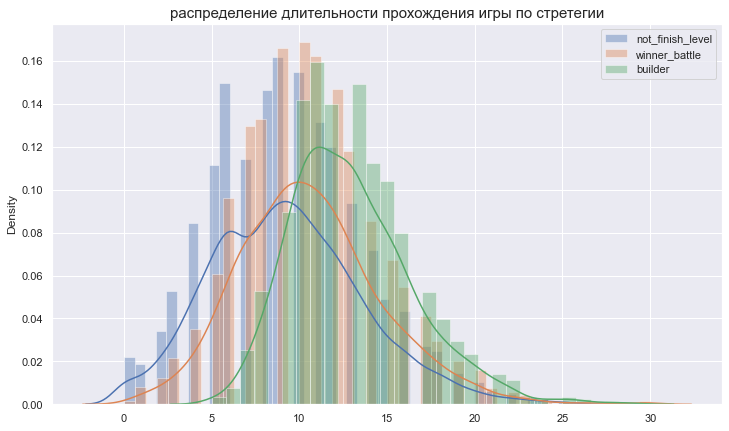

,x_mean
status_strategy,
builder,12.96
winner_battle,10.61
not_finish_level,9.29


In [27]:
# посмотрим на длительность игры пользователя в зависимости от стратегии
plotting(df_good, 'time_play','status_strategy', 'распределение длительности прохождения игры по стретегии')

Расчитаем среднее количество построенных объектов игроками в зависимости от выбранной стратегии Данные показатели наиболее важны при расчете модели монетизации, так как предполагается показ рекламы именно при начале строительства объекта игроком.

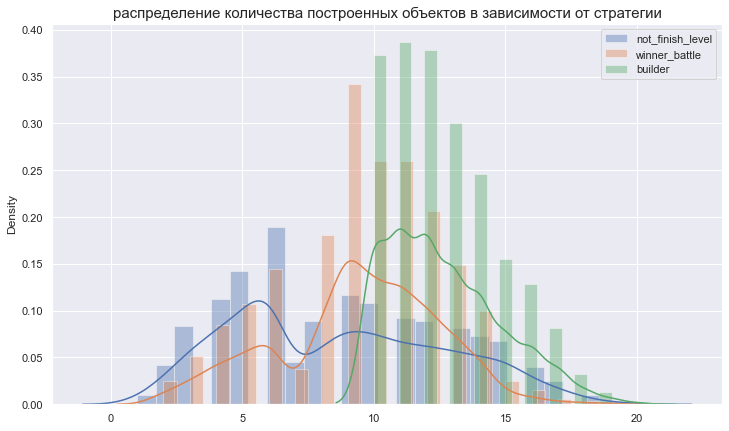

,x_mean
status_strategy,
builder,12.65
winner_battle,9.41
not_finish_level,8.66


In [28]:
# построим график распределения количества построенных объектов игроками в зависимости от стратегии и статуса нахождения в игре

plotting(df_good, 'building', 'status_strategy', 'распределение количества построенных объектов в зависимости от стратегии')

#### Вывод

Количество игроков, прошедших первый уровень путём стратегии строительства: 1866 (32,1 % от количества прошедших уровень).
Количество игроков, прошедших первый уровень путём победы над первым врагом: 3951 (67,9 % от количества прошедших уровень).

Наблюдаем, что большинство игроков предпочитают прохождение уровня игры через победу над врагом. Этот факт следует учесть при дальнейшей оценке модели монетиации.

Игроков, прошедших первый уровень: 5817 чел.  Всего уникальных пользователей 13576. Таким образом больше половины игроков (7759 чел.), находятся еще в процессе игры, выбранную ими стратегию мы пока не знаем, так как стратегия будет известна после завершения ими первого уровня. Но данный факт обязательно нужно учесть при оценке предложенной модели монетизации, так как игроки, находящиеся в процессе игры могут потерять интерес к игре и их достаточно много.

Также видим, что пользователи, выбравшие стратегию победы над врагом проходят игру быстрее, чем те, кто играет по стратегии строительства. Распределение нормальное. Гипотезу о равенстве времени прохождения игры пользователями с разной стратегией  проверим при дальнейшем анализе.

Мы посмотрели как распределяется количество построенных объектов на игрока в зависимости от стратегии. В среднем пользователь стратегии победы над врагом строит меньше (9 ед.), чем пользователи, выбравшие стратегию строительства (12 ед.). Данный показатель важен, так как именно при выборе объекта строительства и планируется показ рекламы. И соответственно, мы видим, что те, кто еще не прошел первый уровень строят меньше объектов (8 ед. в среднем на чел), что возможно сказывается частота показа рекламы. Будем учитывать это при дальнейшем анализе.



<a id="three_4"></a> 
### Расчет расходов на рекламу в зависимости от источника, продуктовые метрики

day,2020-05-03 00:00:00,2020-05-04 00:00:00,2020-05-05 00:00:00,2020-05-06 00:00:00,2020-05-07 00:00:00,2020-05-08 00:00:00,2020-05-09 00:00:00,total
source,,,,,,,,
facebook_ads,935.88,548.35,260.19,177.98,111.77,68.01,38.72,"2,140.90"
instagram_new_adverts,943.20,502.93,313.97,173.07,109.92,71.58,46.78,"2,161.44"
yandex_direct,969.14,554.65,308.23,180.92,114.43,62.96,42.78,"2,233.11"
youtube_channel_reklama,454.22,259.07,147.04,88.51,55.74,40.22,23.31,"1,068.12"
total,"3,302.45","1,865.00","1,029.43",620.48,391.85,242.77,151.59,"7,603.58"


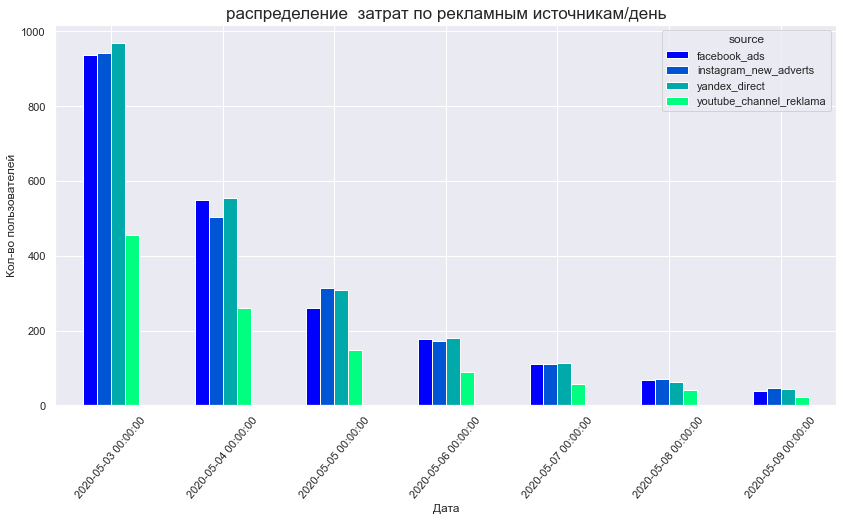

In [29]:
# Построим и визуализируем сводную таблицу с расходами по дням

display(df_costs.pivot_table(index='source', columns='day', values='cost', aggfunc='sum', margins=True, margins_name='total'))

df_costs_pivot = df_costs.pivot_table(index='source', columns='day', values='cost', aggfunc='sum')
df_costs_pivot.T.plot(kind='bar', figsize=(14,7), grid=True, colormap='winter')
plt.title('распределение  затрат по рекламным источникам/день',fontsize=17)
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дата')
plt.xticks(rotation=50);

In [30]:
# Добавим в таблицу с событиями дату первого действия каждого пользователя:
user_first_event = df_good[['user_id', 'first_event_datetime']].rename(columns = {'first_event_datetime':'first_event_date'})
user_first_event['first_event_date'] = user_first_event['first_event_date'].dt.date.astype('datetime64')

game_actions = df_game_actions.merge(user_first_event, how='left', on='user_id')


In [31]:
def dt_time(df, param, frmt):
    """
    Функция заменяет тип поля на datetime по заданному формату frmt.
    Входные параметры:
        `df` - датафрейм
    """
    try:
        df[param] = pd.to_datetime(df[param], format=frmt)
    except:
        print('Проверьте корректность данных в поле', param)
        
# Посчитаем, сколько пользователей пришли в игру в разрезе источника и дня:
count_users = game_actions.groupby(['source', 'first_event_date']).agg(users = ('user_id', 'nunique')).reset_index()
dt_time(count_users, 'first_event_date', '%Y-%m-%d')
# Добавим в таблицу с затратами информацию о количестве привлечённых пользователей по дням:
good_costs = df_costs.merge(count_users, left_on = ['source', 'day'], right_on = ['source', 'first_event_date'], how='outer').sort_values(by=['source','day'])
good_costs

,source,day,cost,first_event_date,users
0,facebook_ads,2020-05-03,935.88,NaT,NaN
1,facebook_ads,2020-05-04,548.35,2020-05-04,"1,184.00"
2,facebook_ads,2020-05-05,260.19,2020-05-05,694.00
3,facebook_ads,2020-05-06,177.98,2020-05-06,345.00
4,facebook_ads,2020-05-07,111.77,2020-05-07,224.00
5,facebook_ads,2020-05-08,68.01,2020-05-08,139.00
6,facebook_ads,2020-05-09,38.72,2020-05-09,84.00
28,facebook_ads,NaT,NaN,2020-05-10,56.00
7,instagram_new_adverts,2020-05-03,943.20,NaT,NaN
8,instagram_new_adverts,2020-05-04,502.93,2020-05-04,"1,452.00"


Видим в таблице смещение на одну строку и это логично, так как рекламу игры запустили 3 мая по всем источникам привлечения, а запущена игра была для пользователей только 4 мая. В связи с этим у нас отсутствуют данные о количестве пользователей 3 мая. Но и рекламирование игры было прекращено 9 мая, а в данных присутствуют пользователи, которые пришли игру 10 мая. Таким образом наблюдаем смещение на один день. Для удобства расчета продуктовых метрик сместим значения колонок'users' и 'first_event_date' на одну строку вверх и удалим строчки с пропусками в колонке 'cost'.


In [32]:
good_costs['users'] = good_costs['users'].shift(-1)
good_costs['first_event_date'] = good_costs['first_event_date'].shift(-1)
good_costs = good_costs.dropna(axis='index', how='any', subset=['cost'])
good_costs

,source,day,cost,first_event_date,users
0,facebook_ads,2020-05-03,935.88,2020-05-04,"1,184.00"
1,facebook_ads,2020-05-04,548.35,2020-05-05,694.00
2,facebook_ads,2020-05-05,260.19,2020-05-06,345.00
3,facebook_ads,2020-05-06,177.98,2020-05-07,224.00
4,facebook_ads,2020-05-07,111.77,2020-05-08,139.00
5,facebook_ads,2020-05-08,68.01,2020-05-09,84.00
6,facebook_ads,2020-05-09,38.72,2020-05-10,56.00
7,instagram_new_adverts,2020-05-03,943.20,2020-05-04,"1,452.00"
8,instagram_new_adverts,2020-05-04,502.93,2020-05-05,796.00
9,instagram_new_adverts,2020-05-05,313.97,2020-05-06,472.00


Расчитаем CAC (customer acquisition cost), или стоимость привлечения клиента, LTV (Lifetime Value) — это прибыль, которую приносит пользователь и ROMI (Return on Marketing Investment) — коэффициент возврата маркетинговых инвестиций. 



In [33]:
# добавим в отчёт стоимость привлечения пользователя в каждый день рекламы
good_costs['cac'] = good_costs['cost'] / good_costs['users']

# добавим количество построенных объектов
count_buildings = game_actions.groupby(['source', 'first_event_date']).agg(buildings = ('building_type', 'count')).reset_index()
dt_time(count_buildings, 'first_event_date', '%Y-%m-%d')
good_costs = good_costs.merge(count_buildings, left_on = ['source', 'first_event_date'], right_on = ['source', 'first_event_date'], how = 'left')

# рассчитаем LTV по источнику, начало строительства бъекта пользователем принимаем за единицу дохода от казаза рекламы

good_costs['ltv'] = (good_costs['buildings'] / good_costs['users'])*0.07    # 0,07 у.е. предполагаемая стоимость показа рекламы

good_costs = good_costs.drop(columns = ['first_event_date'])
good_costs = good_costs[['source' , 'day', 'users', 'buildings', 'cost', 'cac', 'ltv']]
good_costs

,source,day,users,buildings,cost,cac,ltv
0,facebook_ads,2020-05-03,"1,184.00",12494,935.88,0.79,0.74
1,facebook_ads,2020-05-04,694.00,6895,548.35,0.79,0.70
2,facebook_ads,2020-05-05,345.00,3087,260.19,0.75,0.63
3,facebook_ads,2020-05-06,224.00,1789,177.98,0.79,0.56
4,facebook_ads,2020-05-07,139.00,949,111.77,0.80,0.48
5,facebook_ads,2020-05-08,84.00,599,68.01,0.81,0.50
6,facebook_ads,2020-05-09,56.00,318,38.72,0.69,0.40
7,instagram_new_adverts,2020-05-03,"1,452.00",15135,943.20,0.65,0.73
8,instagram_new_adverts,2020-05-04,796.00,7786,502.93,0.63,0.68
9,instagram_new_adverts,2020-05-05,472.00,4221,313.97,0.67,0.63


In [34]:
# Добавим lifetime пользователя в рамках когорты:
game_actions['cohort_lifetime'] = game_actions['date'] - game_actions['first_event_date']
game_actions['cohort_lifetime'] = game_actions['cohort_lifetime'] / np.timedelta64(1,'D')
game_actions['cohort_lifetime'] = round(game_actions['cohort_lifetime']).astype('int')

In [35]:
def cohorts_by_source(source): # source - список источников
    """
    Функция формирует таблицу для когортного анализа по заданному источнику.
    Входной параметр:
        `source` - список с названиями источников
    Выход:
        DataFrame
    """
    cohorts = game_actions[game_actions['source'].isin(source)].groupby(['first_event_date', 'date', 'cohort_lifetime']).agg(
                                                                            count = ('user_id', 'nunique'),
                                                                            buildings = ('building_type', 'count')
                                                                           ).reset_index()
    
    return cohorts
      

In [36]:
def buildings_by_cohorts(cohorts):
    """
    Функция подсчитывает для каждой когорты ltv
    и строит по ним тепловую карту.
    Входной параметр:
        `cohorts` - таблица с когортами
    """
    # Рассчитаем количество построенных объектов на пользователя:
    cohorts['ltv'] = (cohorts['buildings'] / cohorts['count'])*0.07

    output = cohorts.pivot_table(index='first_event_date', 
                                columns='cohort_lifetime', 
                                values='ltv', 
                                aggfunc='mean')

    sns.set(style='white')
    plt.figure(figsize=(16, 5))
    plt.title('LTV (накопительное)')
    
    sns.heatmap(output.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray', 
                square=True,
                cbar=0
               )
    plt.yticks(rotation=0) 
    plt.xlabel('Lifetime когорты, дни')
    plt.ylabel('Когорты')
    plt.show()
    
    

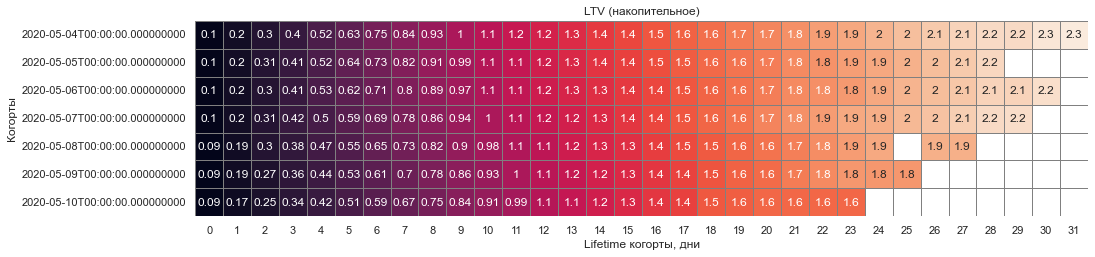

In [37]:
cohorts_total = cohorts_by_source(['youtube_channel_reklama', 'facebook_ads', 'instagram_new_adverts','yandex_direct'])
# Посмотрим на LTV по всем источникам в целом:
buildings_by_cohorts(cohorts_total)

In [38]:
good_costs_new = good_costs.groupby(['source'])['ltv', 'cac'].sum()
display(good_costs_new)

,ltv,cac
source,,
facebook_ads,3.99,5.43
instagram_new_adverts,4.00,4.52
yandex_direct,3.91,3.24
youtube_channel_reklama,3.90,2.82


In [39]:
good_costs_new['romi'] = (good_costs_new['ltv'] - good_costs_new['cac'])/good_costs_new['cac']*100
display(good_costs_new)

,ltv,cac,romi
source,,,
facebook_ads,3.99,5.43,-26.50
instagram_new_adverts,4.00,4.52,-11.64
yandex_direct,3.91,3.24,20.62
youtube_channel_reklama,3.90,2.82,38.00


In [40]:
print('\033[1mLTV всего:',round(good_costs_new['ltv'].sum()))

LTV всего: 16


In [41]:
# Посчитаем окупаемость приложения в целом
good_costs_new = good_costs_new['romi'].sum()
print('\033[1mROMI всего:',round(good_costs_new))

ROMI всего: 20


В итоге мы видим, что при стоимости показа рекламы пользователю в 0,07 у.е., проект в целом окупается на 20 %. 

В связи с тем, что перед нами поставлена задача формирования наиболее эффективной модели монетизации приложения, расчитаем , возможно ли уменьшить количество показа рекламы пользователям и при этом сохранить окупаемость.

Для начала расчитаем, как отразится на окупаемости уменьшение количества показов на 1 %.

In [42]:
# посмотрим, сколько построек от общего количества составляет 1 %
mb_show_adv = good_costs['buildings']*0.01
print(round(mb_show_adv.sum()))

1280


In [43]:
# расчитаем LTV исходя из уменьшения показов на 1 %
good_costs['ltv'] = ((good_costs['buildings']- mb_show_adv) / good_costs['users'])*0.07 
good_costs_new = good_costs.groupby(['source'])['ltv', 'cac'].sum()
good_costs_new_1 = good_costs_new.groupby(['source'])['ltv', 'cac'].sum()

# расчитаем ROMI исходя из уменьшения показов прстроек на 1 %
good_costs_new_1['romi'] = (good_costs_new_1['ltv'] - good_costs_new_1['cac'])/good_costs_new_1['cac']*100
display(good_costs_new_1)
print('\033[1mROMI при уменьшении показа рекламы на 1 % составляет:', round(good_costs_new_1['romi'].sum()))

,ltv,cac,romi
source,,,
facebook_ads,3.95,5.43,-27.24
instagram_new_adverts,3.96,4.52,-12.52
yandex_direct,3.87,3.24,19.41
youtube_channel_reklama,3.86,2.82,36.62


ROMI при уменьшении показа рекламы на 1 % составляет: 16


Таким образом окупаемость рекламных вложений теряет 4 % при уменьшении показа рекламы на 1%. Следовательно, для того, чтобы приложение не ушло в убыток, мы можем максимально уменьшить количество показов на 5 %. Но при таком  показателе сокращения показов и доход тоже будет отсутствовать, и не исключены форс_мажорные обстоятельства, а близко к границе риска подходить не хотелось бы. Поэтому, все же минимум я бы предложила рассмотреть такой, как уменьшение количества показов на 4 % от общего.

Теперь посмотрим, от какого количества показов мы можем себе позволить отказаться и сохранить окупаемость не в процентном, а количественном измерении относительно каждого игрока.

Обобщим ранее произведенные расчеты в проекте для удобства дальнейшего анализа

- Общее количество уникальных пользователей - 13 576 чел. (из них все еще не прошли первый уровень - 7759 чел.)
- Общее количество построенных сооружений в игре - 127 956 ед.
- Среднее количество построек на одного игрока - от 8 до 12 единиц в зависимости от выбранной стратегии.
- 1% от общего количества построенных сооружений составляет 1280 ед.
- ROMI при предложенной модели монетизации составляет 20 %
- ROMI уменьшается на 4 % с каждым процентом уменьшения показов рекламы


Таким образом, видим, что максимальное количество отказа от показов рекламы игроку при строительстве сооружений может составлять - 1280 х 4 = 5120.
Учитывая, что уникальное количество игроков 13 576 чел., видим, что мы не можем отказаться от сокращения показа рекламы на один просмотр для КАЖДОГО игрока. Возможен вариант сокращения показа рекламы для каждого 2-го игрока, который все еще не прошел первый уровень (их на момент анализа - 7759 чел.). Если на начальном этапе тестирования данной модели она покажет позитивный результат повышения притока либо заинтересованности игроков, то возможно при увеличении количества пользователей и сокращения продолжительности времени на прохождение первого уровня, будет увеличен доход, и как следствие окупаемость. При таком результате, мы сможем и дальше понемногу уменьшать показы рекламы при повышении дохода и лояльности игроков.

При общей оценке модели монетизации определим рекомендуемый механизм определения способа сокращения показа рекламы пользователям.

#### Вывод

При проведении анализа бы сделан запрос в отдел маркетинга для уточнения информации о предполагаемой стоимости показа рекламы.

В соответствии с полученной информацией из отдела маркетинга, расчет прибыли  был произведен исходя из стоимости показа рекламы - 0,07 у.е.

Общая сумма затрат на рекламу за период с 03.05.20 по 09.05.10 составляет - **7,603.58 у.е.**

Также расчет сделан именно о предполагаемой прибыли, то есть прибыль по игре пока не поступает в компанию, поэтому расчет метрик LTV и ROMI сделан на предположении, что с первого дня привлечения пользователей в игру осуществлялся показ рекламы и компания получала доход. Так как показ рекламы предполагается при выборе игроком объекта строительства, то и расчет дохода был сделан на основании 1 объект - один показ за 0,07 у.е.

Данных для полного анализа данных метрик недостаточно, так как предложен небольшой период времени привлечения клиентов для анализа и итоговое решение после 7 дней оплаты расходов на трафик пользователей принимать трудно, но тем не менее посмотреть на потенциальную окупаемость по источникам нужно. Эти показатели могут быть важны для настройки мдели монетизации игры.

**Канал привлечения пользователей Ютуб:**

Самые минимальные расходы идут на привлечение пользователей от источника Ютуб, всего за предложенный период с 3 по 9 мая 2020 года было потрачено на этот канал  1,068.12 у.е., но и привлечено было данным каналом меньше всего пользователей  2 686 чел. Показатель LTV по данному каналу  3,90 у.е., САС  2,82 у.е., ROMI  38 %. Окупаемость есть, и лучшая при рассмотрении предложенных 4-х каналов привлечения пользователей.

**Канал привлечения пользователей Яндекс.Директ:**

Также привлекательный канал по окупаемости вложений. Расходы на привлечение пользователей всего  2 233,11 у.е., привлечено самое большое количество пользователей  4817 чел. Показатели продуктовых метрик: LTV  3,91 у.е.,  CAC  3,24 у.е., ROMI  20,62 %.

**Канал привлечения пользователей Инстаграмм:**

Расходы на привлечение пользователей всего - 2 161,44 у.е., привлечено пользователей - 3 347 чел. Показатели продуктовых метрик: LTV - 4 у.е.,  CAC - 4,52 у.е., ROMI - 11,64 % (отрицательный). То есть по данному каналу пока видим предполагаемый убыток при стоимости рекламного показа в 0,07 у.е.

**Канал привлечения пользователей Фейсбук:**

Расходы на привлечение пользователей всего - 2 140,90 у.е., привлечено пользователей - 2 726 чел. Показатели продуктовых метрик: LTV - 3,99 у.е.,  CAC - 5,43 у.е., ROMI - 26,50 % (отрицательный). То есть по данному каналу также пока видим предполагаемый убыток при стоимости рекламного показа в 0,07 у.е.





<a id="four"></a> 
## Проверка гипотез

<a id="four_1"></a> 
### Время прохождения уровня игры различается между пользователями в зависимости способа завершения уровня: через реализацию проекта либо через победу над другим игроком 
 

При проведении исследования в ячейке: [25] мы на графике displot визуализировали распределение относительно длительности прохождения уровня игроками в зависимости от стратегии. Распределение стремиться к нормальному и не зависимы между собой, в связи с чем для проверки гипотезы будем использовать t-критерий Стьюдента.

Сформулируем Нулевую гипотезу (Н0): Среднее время прохождения  первого уровня игры пользователями с различной стратегией - одинаковое.
Альтернативная гипотеза (Н1): Среднее время прохождения  первого уровня игры пользователями с различной стратегией - различается.

In [44]:
# Проверим гипотезу

# создадим переменные для проверки гипотезы
# ранее мы уже формировали объединенные данные по стратегиям игроков в таблицу df_good

strategy_building = df_good.query('status_strategy == "builder"')['time_play_h'].values
strategy_victory = df_good.query('status_strategy == "winner_battle"')['time_play_h'].values

alpha = 0.05 # критический уровень статистической значимости

df_results = st.ttest_ind(strategy_building, strategy_victory)

print('p-значение:', df_results.pvalue)

if (df_results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.408867041388203e-98
Отвергаем нулевую гипотезу


<a id="four_2"></a> 
### Время прохождения уровня игры различается в зависимости от источника перехода пользователя в игровое приложение

Формулируем гипотезы.


Нулева гипотеза (H0): Среднее время прохождения уровня игры одинаковое в зависимости от источника перехода 


Альтернативная гипотеза (H1): Среднее время прохождения уровня игры различается в зависимости от источника перехода 

Проверим распределение.

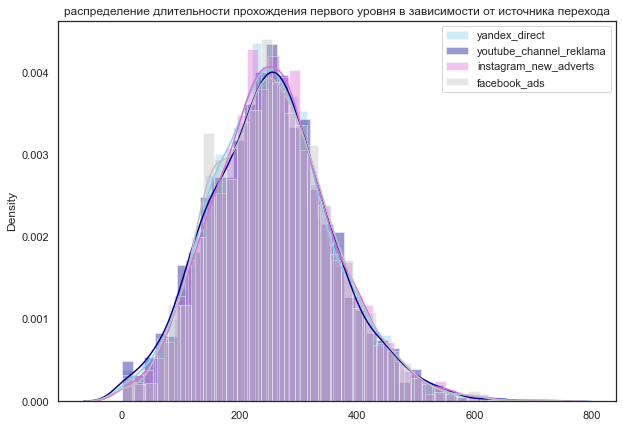

In [45]:
# Напишем переменные по источникам рекламы для удобства дальнейшей работы над проверкой гипотезы

yandex = df_good.query('source == "yandex_direct"')['time_play_h'].values 
youtube = df_good.query('source == "youtube_channel_reklama"')['time_play_h'].values 
instagram = df_good.query('source == "instagram_new_adverts"')['time_play_h'].values  
facebook = df_good.query('source == "facebook_ads"')['time_play_h'].values 

# построим график распределения

plt.figure(figsize=(10,7))
plt.title('распределение длительности прохождения первого уровня в зависимости от источника перехода', fontsize=12)
sns.distplot(df_good, x=yandex, color='skyblue', label='yandex_direct', kde=True)
sns.distplot(df_good, x=youtube, color='darkblue', label='youtube_channel_reklama', kde=True)
sns.distplot(df_good, x=instagram, color='orchid', label='instagram_new_adverts', kde=True)
sns.distplot(df_good, x=facebook, color='silver', label='facebook_ads', kde=True)
plt.legend() 
plt.show()  

Распределение нормальное и выборки не зависимы между собой, в связи с чем для проверки гипотезы будем использовать t-критерий Стьюдента.

При одновременной проверке большого числа гипотез на том же наборе данных вероятность сделать неверное заключение в отношении хотя бы одной из этих гипотез значительно превышает изначально принятый уровень значимости. Для устранения этого эффекта существует большой арсенал методов, различающихся по своей мощности и применимости в разных ситуациях. Применим один из наиболее известных таких методов - поправка Бонферрони. Эта одношаговая процедура позволяет снизить вероятность ложноположительного результата эксперимента. Суть метода — принять альтернативную гипотезу, если:pa/n, где n - количество тестируемых гипотез.

В нашем эксперименте тестируется 6 гипотез, соответственно применим alpha = 0,05/6.

In [46]:
# напишем функцию для расчета проверки гипотезы

def t_test(first_df, second_df, alpha, equal_var):
    alpha = 0.5/6
    results = st.ttest_ind(first_df, second_df, equal_var = equal_var)
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else: 
        print("Не получилось отвергнуть нулевую гипотезу")

In [47]:
t_test(yandex, facebook, 0.05, False)

p-значение: 0.26720573137682463
Не получилось отвергнуть нулевую гипотезу


In [48]:
t_test(instagram, facebook, 0.05, False)

p-значение: 0.6095912936634867
Не получилось отвергнуть нулевую гипотезу


In [49]:
t_test(youtube, facebook, 0.05, False)

p-значение: 0.22489713325188448
Не получилось отвергнуть нулевую гипотезу


In [50]:
t_test(yandex, instagram, 0.05, False)

p-значение: 0.07661521032499659
Отвергаем нулевую гипотезу


In [51]:
t_test(yandex, youtube, 0.05, False)

p-значение: 0.7868745862630966
Не получилось отвергнуть нулевую гипотезу


In [52]:
t_test(instagram, youtube, 0.05, False)

p-значение: 0.07485802969234673
Отвергаем нулевую гипотезу


### Вывод

При проверке нулевой гипотезы (Н0) "Среднее время прохождения первого уровня игры пользователями с различной стратегией - одинаковое" она была отвергнута, следовательно, высока вероятность того, что длительность прохождения уровня игроками с разной стратегией отличается. 

При проверке нулевой гипотезы (Н0) "Среднее время прохождения уровня игры одинаковое в зависимости от источника перехода" она была отвергнута для пары источников "Инстаграм", "Ютуб", и для пары "Яндекс", "Инстаграм". Для остальных пар источников, гипотеза не была отвергнута, следовательно, высока вероятность того, что длительность прохождения уровня игроками, которые пришли из этих источников привлечения пользователя - одинаковое. 





<a id="five"></a> 
## Оценка предполагаемой (разработанной до проведения анализа) модели монетизации

Итак, нам была предложена модель монетизации игры "Космческие братья".

Данные предоставлены по привлечению пользователей с 3 по 9 мая 2020 года. Запуск игры 4 мая, данные предоставлены по поведению игроков пришедших в игру с 4 по 10 мая. Исследуемый период с 03.05.20 г. по 05.06.20 г.

Так как предложенная для проекта модель монетизации только в разработке, то приходим к выводу, что анализ данных проводится также в июне-июле 2020 г.

Затраты по источникам привлечения пользователей известны. Доход предполагается получать при показе рекламы пользователям при выборе ими объекта строительства. Стоимость показа предполагается - 0,07 у.е.

**При проведении анализа данных было установлено:**


- Общее количество уникальных пользователей - 13 576 чел. (из них все еще не прошли первый уровень - 7759 чел.)
- Общее количество построенных сооружений в игре - 127 956 ед.
- Общая сумма затрат на привлечение пользователей - 7,603.58 у.е.
- Среднее количество построек на одного игрока - от 8 до 12 единиц в зависимости от выбранной стратегии.
- 1% от общего количества построенных сооружений составляет 1280 ед.
- ROMI при предложенной модели монетизации составляет 20 %
- ROMI уменьшается на 4 % с каждым процентом уменьшения показов рекламы


Самое высокое количество пользователей переходят из источника Яндекс Директ - 4817 (35,48 %) чел., на втором месте по численности пользователи трафика Инстаграмм - 3347 (24,65 %) чел., Ютюб и Фейсбук привлекают практически одинаковое количество пользователей : 2686 (20,08 %) и 2726 (19,78 %) соответственно.

Относительно совершенных событий: пользователи трафика Яндекс Директ совершают самое большое количество событий - 47694, что логично, так как и пользователей переходит из этого источника больше. На втором месте по совершению событий пользователи трафика Инстаграмм - 33 757, и далее по убыванию Фейсбук - 27 672 события и Ютуб - 26 516 событий.


Количество игроков, прошедших первый уровень путём стратегии строительства: 1866 (32,1 % от количества прошедших уровень). Количество игроков, прошедших первый уровень путём победы над первым врагом: 3951 (67,9 % от количества прошедших уровень).

**Таким образом, большинство игроков предпочитают прохождение уровня игры через победу над врагом. Но такие пользователи и строят меньше зданий, соответственно, доход от показа им рекламы будет меньше.**



Игроков, прошедших первый уровень: 5817 чел. Всего уникальных пользователей 13576. Таким образом больше половины игроков (7759 чел.), находятся еще в процессе игры, выбранную ими стратегию мы пока не знаем, так как стратегия будет известна после завершения ими первого уровня. Данный факт может сигнализировать о том, что игроки, находящиеся в процессе игры могут потерять интерес к игре и их достаточно много. **Возможно пользователи теряют интерес к иге по причине частого показа им рекламы, данный факт возможно понять только применив эксперементальную модель монетизации с сокращением количества показов рекламы.**



Пользователи, выбравшие стратегию победы над врагом проходят игру быстрее, чем те, кто играет по стратегии строительства, что подтверждено при проверке гипотезы. 

В среднем пользователь стратегии победы над врагом строит меньше (9 ед.), чем пользователи, выбравшие стратегию строительства (12 ед.). Данный показатель важен, так как именно при выборе объекта строительства и планируется показ рекламы. И соответственно, мы видим, что те, кто еще не прошел первый уровень строят меньше объектов (8 ед. в среднем на чел), что может говорить о том, что рекламы показывают им меньше, но интерес при этом угасает, так как длительность прохождения уровня увеличивается.

Самые привлекательные каналы для выбранной модели монетизации это **Youtube и Yandex.Direct**. Данные каналы интересны с точки зрения окупаемости при стоимости показа рекламы пользователю 0,07 у.е. 

**Канал привлечения пользователей Ютуб:**

Самые минимальные расходы идут на привлечение пользователей от источника Ютуб, всего за предложенный период с 3 по 9 мая 2020 года было потрачено на этот канал 1,068.12 у.е., но и привлечено было данным каналом меньше всего пользователей 2 686 чел. Показатель LTV по данному каналу 3,90 у.е., САС 2,82 у.е., ROMI 38 %. Окупаемость есть, и лучшая при рассмотрении предложенных 4-х каналов привлечения пользователей.

**Канал привлечения пользователей Яндекс.Директ:**

Также привлекательный канал по окупаемости вложений. Расходы на привлечение пользователей всего 2 233,11 у.е., привлечено самое большое количество пользователей 4817 чел. Показатели продуктовых метрик: LTV 3,91 у.е., CAC 3,24 у.е., ROMI 20,62 %.

Окупаемость модели монетизации  при использовании для привлечения пользователей каналов  **Facebook и Instagramm** при стоимости показа рекламы игрокам в 0,07 у.е. - отрицательная. 

**Канал привлечения пользователей Инстаграмм:**

Расходы на привлечение пользователей всего - 2 161,44 у.е., привлечено пользователей - 3 347 чел. Показатели продуктовых метрик: LTV - 4 у.е., CAC - 4,52 у.е., ROMI - 11,64 % (отрицательный). То есть по данному каналу пока видим предполагаемый убыток при стоимости рекламного показа в 0,07 у.е.

**Канал привлечения пользователей Фейсбук:**

Расходы на привлечение пользователей всего - 2 140,90 у.е., привлечено пользователей - 2 726 чел. Показатели продуктовых метрик: LTV - 3,99 у.е., CAC - 5,43 у.е., ROMI - 26,50 % (отрицательный). То есть по данному каналу также пока видим предполагаемый убыток при стоимости рекламного показа в 0,07 у.е.

При проверке длительности прохождения пользователями игры различие этой длительности подтвердилось у пользователей, пришедших из источников (сравнение в паре) Инстаграмм, Ютуб и пара Яндекс, Инстаграмм. Не подтвердилось различие этой длительности по остальным парам источников привлечения игроков. Длительность прохождения игры может характеризовать заинтересованность игроков в игре (чем дольше проходит игрок уровень, тем, предположительно, менее проявляется интерес к игре и повышается возможность оттока пользователей. Проверка данной гипотезы показала, что преимущества того или иного источника привлечения пользователя - нет, в связи с чем, возможен отказ от расходов на более дорогие источники привлечения игроков.

В целом предполагаемая модель монетизации возможно будет эффективна. Как указывалось выше, окупаемость (ROMI) при предложенной модели монетизации составляет 20 %.

Максимальное количество сокращения показов рекламы игроку при строительстве сооружений может составлять - 5120 ед. (на данный момент предельно на 4 % от общего количества показов).
Учитывая, что уникальное количество игроков 13 576 чел., видим, что мы не можем отказаться от сокращения показа рекламы на один просмотр для КАЖДОГО игрока. Возможен вариант сокращения показа рекламы для каждого 2-го игрока, который все еще не прошел первый уровень (их на момент проведения анализа - 7759 чел.) На начальном этапе тестирования такой модели с сокращенными показами рекламы, может показать результат повышения притока либо заинтересованности игроков. И возможно при увеличении количества пользователей и сокращения продолжительности времени на прохождение первого уровня, будет увеличен доход, и как следствие окупаемость. При таком результате, мы сможем и дальше понемногу уменьшать показы рекламы при повышении дохода и лояльности игроков.

Но хотелось бы отметить, при позитивных моментах перспективы внедрения модели монетизации при сокращении количества показов рекламы, есть риски получить отрицательное значение окупаемости. Данную модель следует внедрять постепенно, сокращая процент показов пошагово и оценивая результат.

**Механизм определения сокращения количества показов рекламы для игроков**

- Применить сокращение рекламы для игроков, которые еще не прошли 1-й уровень (таких 7 759 чел.), так как именно этих игроков нам нужно удержать и заинтересовать в продолжении игры.
- В среднем игроки, не прошедшие первый уровень построили 8 объектов. Количество объектов, который могут построить игроки, исходя из среднего по стратегиям прошедших 1-й уровень от 9 до 12.
- Сократить показ рекламы для игроков, не прошедших уровень на 1 (один) показ, в шаге строительства 9-го объекта, так как это самый ближайший шаг для таких игроков. Таким образом, мы не будем затягивать время применения модели сокращения показов рекламы для удержания пользователя.
- Ограничить отсутствие показа рекламы игрокам на 9-м объекте количеством в 5 120 ед.  При превышении этого предельного количества отказов от показа рекламы - возможен отрицательный показатель окупаемости. В связи с тем, что мы не знаем, сколько из пользователей, не прошедших первый уровень захотят продолжить игру и когда они продолжат, предложен именно такой (ограничивающий общее количество) вариант расчета и определения возможности отказа от показа рекламы.



При отказе от таких источников привлечения игроков, как Фейсбук и Инстаграмм, мы можем увеличить окупаемость и воспользоваться этим для увеличения количества сокращения показов рекламы, что может сказаться положительно на заинтересованности пользователей.



<a id="six"></a> 
## Общие выводы и рекомендации по формированию модели монетизации игрового приложения

**Общие выводы**

- Предлагаемая модель монетизации эффективна при использовании всех каналов привлечения, при стоимости одного показа рекламы игрокам 0,7 у.е. Окупаемость - 20 %.
- При отдельном анализе источников привлечения пользователей  **Facebook** и **Instagram** модель монетизации показывает отрицательную метрику окупаемости.
- Продолжительность прохождения игроками первого уровня различается в зависимости от выбранной пользователем стратегии.
- Продолжительность прохождения первого уровня пользователями, привлеченными всеми источниками, не различается.
- Наблюдается угасание интереса пользователей к игре, о чем свидетельствует увеличение длительности прохождения первого уровня более чем половиной от общего количества игроков.
- Для сохранения и увеличения заинтересованности пользователей допустимо сокращение показов рекламы до 4 % от общего количества показов , что составляет 5120 показов всего (в среднем одно сокращение на 3-х пользователей).
- 67,9 % игроков от числа прошедших первый уровень, предпочитают стратегию игры "победа над врагом".
- Более привлекательными каналами привлечения пользователей относительно окупаемости и количества привлечения игроков являются источники: **Яндекс.Директ** и **Ютуб**.

**Предлагаемая оптимальная модель монетизации при стоимости клика показа рекламы - 0,07 у.е.:**

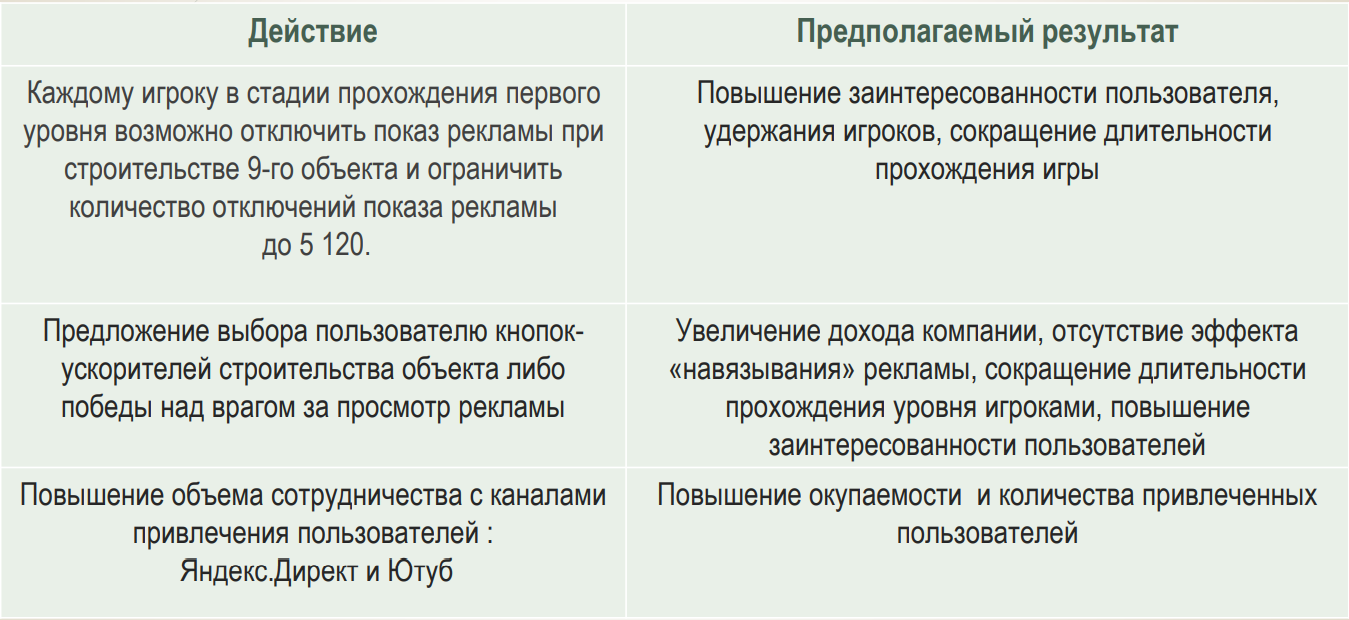

**Рекомендации отделу маркетинга:**

1. Преобладающее количество игроков, которые выбирают стратегию игры "Победа над врагом" свидетельствует о том, что пользователи предпочитают проходить игру быстрее, предпочитают сражения. Данным фактом можно воспользоваться для увеличения доходности игры. А именно: Игрокам, которые вступают в сражения предлагать за просмотр рекламы разные "фишки" для ускорения их победы, например, дополнительные "жизни" и тд. Также при таком подходе, мы НЕ НАВЯЗЫВАЕМ игроку рекламу, он сам решает - смотреть ее или нет. Соответственно это увеличит доход и не повлияет на отток пользователей.
2. Для пользователей, выбравших стратегию "Строительства" также рекомендую внедрить какие-либо "ускорители" строительства зданий за просмотр рекламы, что также увеличит доход и нивелирует "навязывание" рекламы, так как решение игрок принимает самостоятельно о просмотре.
3. Применив рекомендации, изложенные в п. 1 и п. 2, мы также решаем проблему длительности прохождения игры теми пользователями, которые находятся еще на стадии прохождения первого уровня, повышаем интерес к игре, ускоряя прохождение первого уровня, получая при этом дополнительный доход. Таким образом мы "подтягиваем" к завершению первого уровня всех игроков.
5. Для увеличения заинтересованности игроков возможно сокращение показа рекламы не более чем на 4 % (5120 ед.)от общего количества показов. Данный процент показов актуален на дату проведения анализа, в последующем он может быть скорректирован как сторону увеличенния (при эффективности), так и в сторону уменьшения.
4. В связи с тем, что игра только сравнительно недавно была запущена, то отказываться от "Дорогих" каналов привлечения, таких как Фейсбук и Инстаграм, пока не  рекомендую. Дополнительная популяризация игры на начальном этапе ее запуска очень важна. Применив рекомендации, изложенные в п.1,2 для увеличения окупаемости по этим источникам, через месяц снова провести анализ данных для принятия окончательного решения.